<a href="https://githubtocolab.com/rramosp/ai4eng_example_project/blob/main/03%20-%20Modelos-e-iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')


## 1. Lectura y concatenación de los Dataset

In [2]:
#cargar los datos
building_met = pd.read_csv("building_metadata.csv")
train = pd.read_csv("train.csv")
weather_train = pd.read_csv("weather_train.csv")

In [3]:
building_met

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [4]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [5]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [6]:
#Concatenamos los datos de train con building_met
train = train.merge(building_met,on = 'building_id',how = 'left')

In [8]:
#Contatenamos los datos con el dataset weather_train
train = train.merge(weather_train, on=['site_id','timestamp'], how='left')

In [9]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [10]:
#Función para obtener información de la variable timstamp como mes, dia de la semana, etc
def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [11]:
train = breakdown_timestamp(train)

In [12]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,NaN,25.0,...,NaN,1019.7,0.0,0.0,0,1,4,1,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216096,1445,0,2016-12-31 23:00:00,4.825,15,Education,4298,NaN,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216097,1446,0,2016-12-31 23:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016
20216098,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,...,-1.0,1008.5,180.0,8.8,23,31,5,366,12,2016


## 4. Tratamiento de datos

#### 4.1. Remoción de las lecturas cero de la variable objetivo

Como se se mencionó anteriormente al analizar la variable objetivo, se observó que existes muchas lecturas de valor cero para la variable objetivo (meter_reading). Debido a esto se opta por eliminar las filas que contengan un valor cero para la variable objetivo ya que esto indica que no se tiene una disponibilidad de la medición y estos no podrían utilizarse para entrenar.

In [31]:
meter_readings_zero = list(train[train.meter_reading == 0].index) #lista con los indices de los valores que tienen lecturas 0
train.drop(meter_readings_zero, axis = 0, inplace = True) #eliminar filas con lecturas cero en la variable objetivo
print('Nuevo tamaño de los datos: ',train.shape)

Nuevo tamaño de los datos:  (18342124, 22)


#### 4.2. Eliminación de las columnas con muchos datos faltantes

Del análisis exploratorio de las variables, se encontró que existen variables que contienen gran cantidad de datos faltantes. En este caso se optará por eliminar las columnas en las que los datos faltantes representen el 50% o más de la totalidad de los datos. Siguiendo este criterio se eliminan las variables "floor_count", "year_built".

In [32]:
criterio = len(train) * 0.5 #criterio para eliminar la columna (50% de las filas que se tienen)
train.dropna(axis=1, thresh = criterio, inplace = True) #eliminación de las columnas con 50% o más de datos faltantes
print('New Shape of Train Data:',train.shape)

New Shape of Train Data: (18342124, 20)


#### 4.4. Relleno de datos faltantes
Anteriormente se optó por eliminar las columnas que poseian el 50% o más en datos en datos faltantes, sin embargo, aun quedan variables con datos faltantes en el dataset. Para estas columnas se rellenaran los valores faltantes al reemplazarlos por la media de los valores con los que se cuenta para cada columna.

In [33]:
train['cloud_coverage'].fillna(train.cloud_coverage.median(), inplace=True)
train['sea_level_pressure'].fillna(train.sea_level_pressure.median(), inplace=True)
train['precip_depth_1_hr'].fillna(train.precip_depth_1_hr.median(), inplace=True)
train['wind_direction'].fillna(train.wind_direction.median(), inplace=True)
train['wind_speed'].fillna(train.wind_speed.median(), inplace=True)
train['dew_temperature'].fillna(train.dew_temperature.median(), inplace=True)
train['air_temperature'].fillna(train.air_temperature.median(), inplace=True)

In [34]:
train.isnull().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
day                   0
dayofweek             0
dayofyear             0
month                 0
year                  0
dtype: int64

#### 4.4. Adición de la estación y variable para saber si esta de día o de noche

Para este análisis se encuentra interesante el hecho de saber de que estación del año es el cada dato, ya que normalmente en sistemas que ver con calentamiento de agua, o enfriadores de agua para sistemas de aire acondicionado, o sistemas de vapor, la estación del año puede influir en la carga que se impone en los sistemas aumentando o disminuyendo su consumo. También se puede tener que ciertas aplicaciones sean mas usadas en una estación que otra, como por ejemplo el uso del agua caliente en verano, el cual podría reducirse en esta estación. Además de esto la carga también tiene variaciones en el día o noche, y los consumos pueden presentar una variación dependiendo de esto.

In [35]:
# Adicionamos la estación del año, lo cual puede mejorar el análisis

train['season'] = train['timestamp'].apply(lambda x: 'Spring' if x.month==3 or x.month==4 or x.month==5 else 
                                                  'Summer' if x.month==6 or x.month==7 or x.month==8 else 
                                                  'Autumn' if x.month==9 or x.month==10 or x.month==11 else 
                                                  'Winter')

#Adicionamos una variable para saber si es de día, 1 es de día, 0 es de noche
train['isDayTime'] = train['timestamp'].apply(lambda x: 1 if x.hour >=6 and x.hour <=18 else 0)

In [36]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,2016-01-01,3.993413,0,Retail,9.110078,25.0,6.0,20.0,...,0.0,0.0,0,1,4,1,1,2016,Winter,0
72,74,0,2016-01-01,3.784219,0,Parking,12.867830,25.0,6.0,20.0,...,0.0,0.0,0,1,4,1,1,2016,Winter,0
91,93,0,2016-01-01,3.978196,0,Office,10.415443,25.0,6.0,20.0,...,0.0,0.0,0,1,4,1,1,2016,Winter,0
103,105,0,2016-01-01,3.190624,1,Education,10.832181,3.8,0.0,2.4,...,240.0,3.1,0,1,4,1,1,2016,Winter,0
104,106,0,2016-01-01,0.318163,1,Education,8.589514,3.8,0.0,2.4,...,240.0,3.1,0,1,4,1,1,2016,Winter,0


#### 4.5. Transformación de las variables categoricas
Las variables categoricas, como lo son en este caso "primary_use" y "season" pueden ser utiles a la hora de realizar el análisis, sin embargo, no pueden usadas en la forma categorica, por lo que se deben convertir en variables numericas que si podamos utilzar para entrenar un modelo.

In [37]:
var_categoricas = ['primary_use', 'season']
encoder = preprocessing.LabelEncoder()

for i in var_categoricas:
    
    train[i] = encoder.fit_transform(train[i])
    
print (train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18342124 entries, 45 to 20216099
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int64         
 5   primary_use         int32         
 6   square_feet         float64       
 7   air_temperature     float64       
 8   cloud_coverage      float64       
 9   dew_temperature     float64       
 10  precip_depth_1_hr   float64       
 11  sea_level_pressure  float64       
 12  wind_direction      float64       
 13  wind_speed          float64       
 14  hour                uint8         
 15  day                 uint16        
 16  dayofweek           uint8         
 17  dayofyear           uint16        
 18  month               uint8         
 19  year                uint16        
 20 

In [38]:
train = train.drop(['timestamp'],axis=1) #eliminamos la columna timestamp ya que no se utilizará

In [39]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,3.993413,0,11,9.110078,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
72,74,0,3.784219,0,8,12.867830,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
91,93,0,3.978196,0,6,10.415443,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
103,105,0,3.190624,1,0,10.832181,3.8,0.0,2.4,0.0,...,240.0,3.1,0,1,4,1,1,2016,3,0
104,106,0,0.318163,1,0,8.589514,3.8,0.0,2.4,0.0,...,240.0,3.1,0,1,4,1,1,2016,3,0


## 5. Métodos Supervisados


#### 5.1. Selección de Modelos

##### Métrica: 
La métrica para medir el desempeño de los modelos es el RMSLE (Root Mean Squared Logarithmic Error), sin embargo, ya que aplicamos una transformación logarítmica sobre la variable objetivo (meter_reading), podemos usar directamente el RMSE(Root Mean Squared Error) para obtener el valor de la métrica.

In [45]:
#Función para reportar el error del modelo
def report_cv_score(z):
    
    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

In [46]:
#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):
    
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [41]:
X = train.drop(['meter_reading'],axis = 1)
y = train['meter_reading'].values

In [45]:
#eliminamos las variables con menos correlación según el análisis realizado
X = X.drop(['dayofyear','month','hour','dew_temperature','day','precip_depth_1_hr','air_temperature',
                           'sea_level_pressure','wind_direction','dayofweek','wind_speed','cloud_coverage','year'],axis = 1)

In [47]:
#--------Partición de los datos------------

from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(18342124, 7) (18342124,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(12839486, 7) (5502638, 7)


In [43]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [49]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  1.37496 (± 0.00055959 )
RMSLE Train:  1.37571 (± 0.00041960 )
---------
RMSLE Test:  1.26651 (± 0.00036441 )
RMSLE Train:  1.26654 (± 0.00027286 )
---------
RMSLE Test:  1.26123 (± 0.00626660 )
RMSLE Train:  1.26141 (± 0.00636801 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


Los modelos que dan el mejor rendimiento son el RandomForest y DesicionTree, por lo que tomarán estos dos para trabajar.

#### 5.2. Mejores hiperparámetros de los modelos seleccionados

Se usará la herramienta de la libreria Scikit-Learn que permite analizar diferentes hiperparámetros para un modelo con el fin de obtener la mejor selección de los mismos y obtener un modelo más robusto. Esta heramient utiliza una metodología de cross-validation y se le puede brindar un diccionario con diferentes valores para cada hiperparámetros y así hallar cual es la mejor opción.

In [51]:
from sklearn.model_selection import GridSearchCV

##### 5.2.1. Desicion Tree

In [51]:
#Esta celda puede tomar un tiempo considerable en su ejecución
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [52]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=15)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 15}


###### Implementación del mejor Decision Tree

In [54]:
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

DecisionTreeRegressor(max_depth=15)

In [55]:
#Desempeño del modelo Desicion Tree seleccionado

print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  0.67479
RMSLE del Decision Tree seleccionado:  0.67531


##### 5.2.2. Random Forest

In [56]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [57]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=5)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 5}


###### Implementación del mejor Random Forest

In [58]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=9, n_estimators=5)

In [59]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  1.01675
RMSLE del Random Forest seleccionado:  1.01695


## 6. Métodos no supervisados

#### 6.1. PCA

In [40]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,...,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,3.993413,0,11,9.110078,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
72,74,0,3.784219,0,8,12.867830,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
91,93,0,3.978196,0,6,10.415443,25.0,6.0,20.0,0.0,...,0.0,0.0,0,1,4,1,1,2016,3,0
103,105,0,3.190624,1,0,10.832181,3.8,0.0,2.4,0.0,...,240.0,3.1,0,1,4,1,1,2016,3,0
104,106,0,0.318163,1,0,8.589514,3.8,0.0,2.4,0.0,...,240.0,3.1,0,1,4,1,1,2016,3,0


In [41]:
X = train.drop(['meter_reading'],axis = 1)
y = train['meter_reading'].values

In [62]:
X.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,dayofweek,dayofyear,month,year,season,isDayTime
45,46,0,0,11,9.110078,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1,1,2016,3,0
72,74,0,0,8,12.867830,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1,1,2016,3,0
91,93,0,0,6,10.415443,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,0,1,4,1,1,2016,3,0
103,105,0,1,0,10.832181,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,1,4,1,1,2016,3,0
104,106,0,1,0,8.589514,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,1,4,1,1,2016,3,0


In [47]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_t = pca.fit_transform(X)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Rdm_forest.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Rdm_forest.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')
    

(12839486, 1) (5502638, 1)
RMSLE del modelo con  1 elementos:  1.50058
------------
(12839486, 3) (5502638, 3)
RMSLE del modelo con  3 elementos:  1.47617
------------
(12839486, 5) (5502638, 5)
RMSLE del modelo con  5 elementos:  1.47514
------------
(12839486, 7) (5502638, 7)
RMSLE del modelo con  7 elementos:  1.47516
------------
(12839486, 9) (5502638, 9)
RMSLE del modelo con  9 elementos:  1.47559
------------
Mejor RMSLE:  1.47514   ; obtenido con  5  componentes para PCA


In [49]:
#MEJOR PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(12839486, 5) (5502638, 5)


In [52]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [53]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 15}


In [54]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

(12839486, 5) (5502638, 5)


RandomForestRegressor(max_depth=9, n_estimators=15)

In [55]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

RMSLE del Random Forest en entrenamiento:  1.47320
RMSLE del Random Forest seleccionado:  1.47460


#### 6.2. NMF

Para aplicar este método debemos eliminar las variables que contengan valores negativos

In [56]:
X2 = X.drop(['precip_depth_1_hr','air_temperature','dew_temperature'],axis=1)

In [61]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=15)
for i in components:
    nmf = NMF(n_components = i)
    X_t = nmf.fit_transform(X2)
    
    #Partición de datos
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
    Xtv, Xts, ytv, yts = train_test_split(X_t, y, test_size=test_size)
    print (Xtv.shape, Xts.shape)
    
    Des_tree.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')

(12839486, 1) (5502638, 1)
RMSLE del modelo con  1 elementos:  1.67997
------------
(12839486, 3) (5502638, 3)
RMSLE del modelo con  3 elementos:  1.15361
------------
(12839486, 5) (5502638, 5)
RMSLE del modelo con  5 elementos:  1.20726
------------
(12839486, 7) (5502638, 7)
RMSLE del modelo con  7 elementos:  1.33038
------------
(12839486, 9) (5502638, 9)
RMSLE del modelo con  9 elementos:  1.58510
------------
Mejor RMSLE:  1.15361   ; obtenido con  3  componentes para PCA


In [63]:
#MEJOR NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(12839486, 3) (5502638, 3)


In [64]:
#Nota: esta celda requiere de gran tiempo para completarse
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size), 
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [65]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=15)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 15}


In [66]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=15)
Des_tree.fit(Xtv, ytv)

(12839486, 3) (5502638, 3)


DecisionTreeRegressor(max_depth=15)

In [67]:
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  1.15107
RMSLE del Decision Tree seleccionado:  1.15824


## 7. Curvas de aprendizaje

Usamos el módulo learnin_curve de sk.leanr.model_selection, mediante el cual al brindarle información de los tamaños del dataset, el tipo de estimador y el método de hacer los split para la metodología de cross-validation

#### 7.1. Métodos supervisados

In [69]:
X = train.drop(['meter_reading'],axis = 1)
y = train['meter_reading'].values
X = X.drop(['dayofyear','month','hour','dew_temperature','day','precip_depth_1_hr','air_temperature',
                           'sea_level_pressure','wind_direction','dayofweek','wind_speed','cloud_coverage','year'],axis = 1)

In [70]:

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo (solo se usan para el testeo final de los modelos que se seleccionen)
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(18342124, 7) (18342124,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(12839486, 7) (5502638, 7)


##### 7.1.1. Decision Tree

In [101]:
Des_tree1 = DecisionTreeRegressor(max_depth=15)
train_sizes, train_scores, valid_scores = learning_curve(Des_tree1, Xtv, ytv, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

In [114]:
train_mean

array([0.67136584, 0.670353  , 0.67150684, 0.67410453])

In [116]:
valid_mean

array([0.67389975, 0.67185945, 0.67244869, 0.67475607])

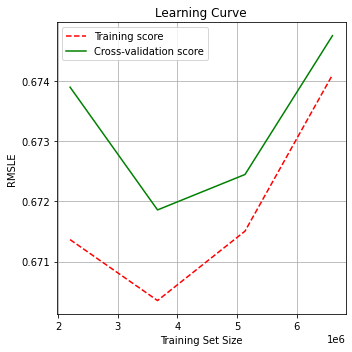

In [131]:
train_scores = np.abs(train_scores)
valid_scores = np.abs(valid_scores)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.subplots(1, figsize=(5,5))
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



plt.grid()
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [45]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9], 
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

##### 7.1.2. Random Forest

In [134]:
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)

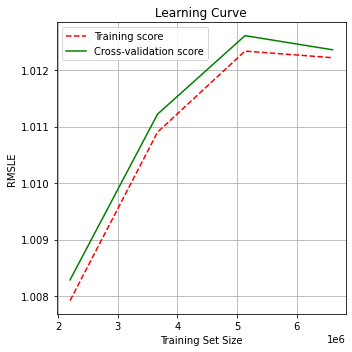

<module 'matplotlib.pyplot' from 'C:\\Users\\danie\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [135]:
lc_plot(Rdm_forest,Xtv,ytv)

#### 7.2. Método no supervisado + Método supervisado

##### 7.2.1. PCA + Random Forest

In [40]:
X = train.drop(['meter_reading'],axis = 1)
y = train['meter_reading'].values


In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y, test_size=test_size)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)

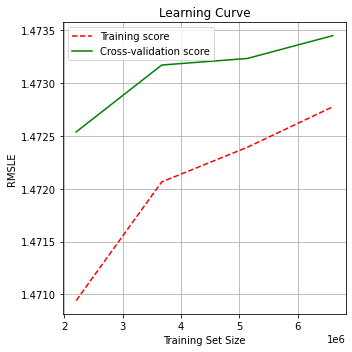

<module 'matplotlib.pyplot' from 'C:\\Users\\danie\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [46]:
lc_plot(Rdm_forest,Xtv,ytv)

##### 7.2.2. NMF + Decision Tree

In [47]:
X2 = X.drop(['precip_depth_1_hr','air_temperature','dew_temperature'],axis=1)

In [49]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=15)

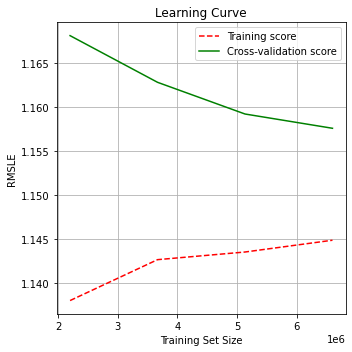

<module 'matplotlib.pyplot' from 'C:\\Users\\danie\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
lc_plot(Des_tree,Xtv,ytv)